## **HBR과 relative velocity의 상관관계**

## **import**


In [1]:
from sgp4.api import Satrec,jday
import matplotlib.pyplot as plt
import numpy as np
from datetime import  datetime
import pandas as pd
import json
from tqdm import tqdm
from math import sqrt


## **상대속도에 따른 HBR 분포**
x-axis : relative velocity (km)  y-axis : HBR

Text(0, 0.5, 'Celestrak HBR (KM)')

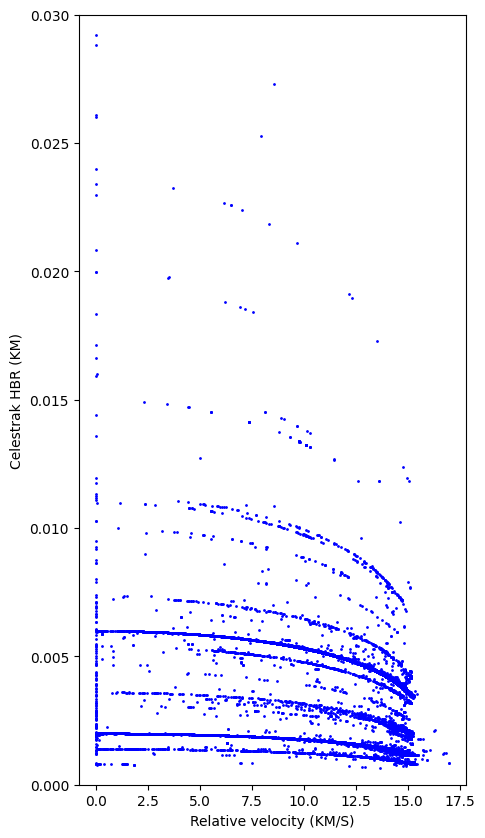

In [4]:
data_ca = pd.read_csv('../conjunction_assesement_result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h_HBR.csv')
plt.figure(figsize=(5,10))
plt.ylim(0,0.03)
x1= data_ca['TCA_RELATIVE_SPEED']
y1=(data_ca['HBR_CELESTRAK'])
plt.scatter(x1,y1,s=1,color='b')
plt.xlabel('Relative velocity (KM/S)')
plt.ylabel('Celestrak HBR (KM)')


## **object class 별 상대속도에 따른 HBR 분포**
x-axis : relative velocity (km/s) , y-axis : HBR (km) </br>

object class : esa에서 사용하는 단어</br>
object type : space-track에서 사용하는 단어


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


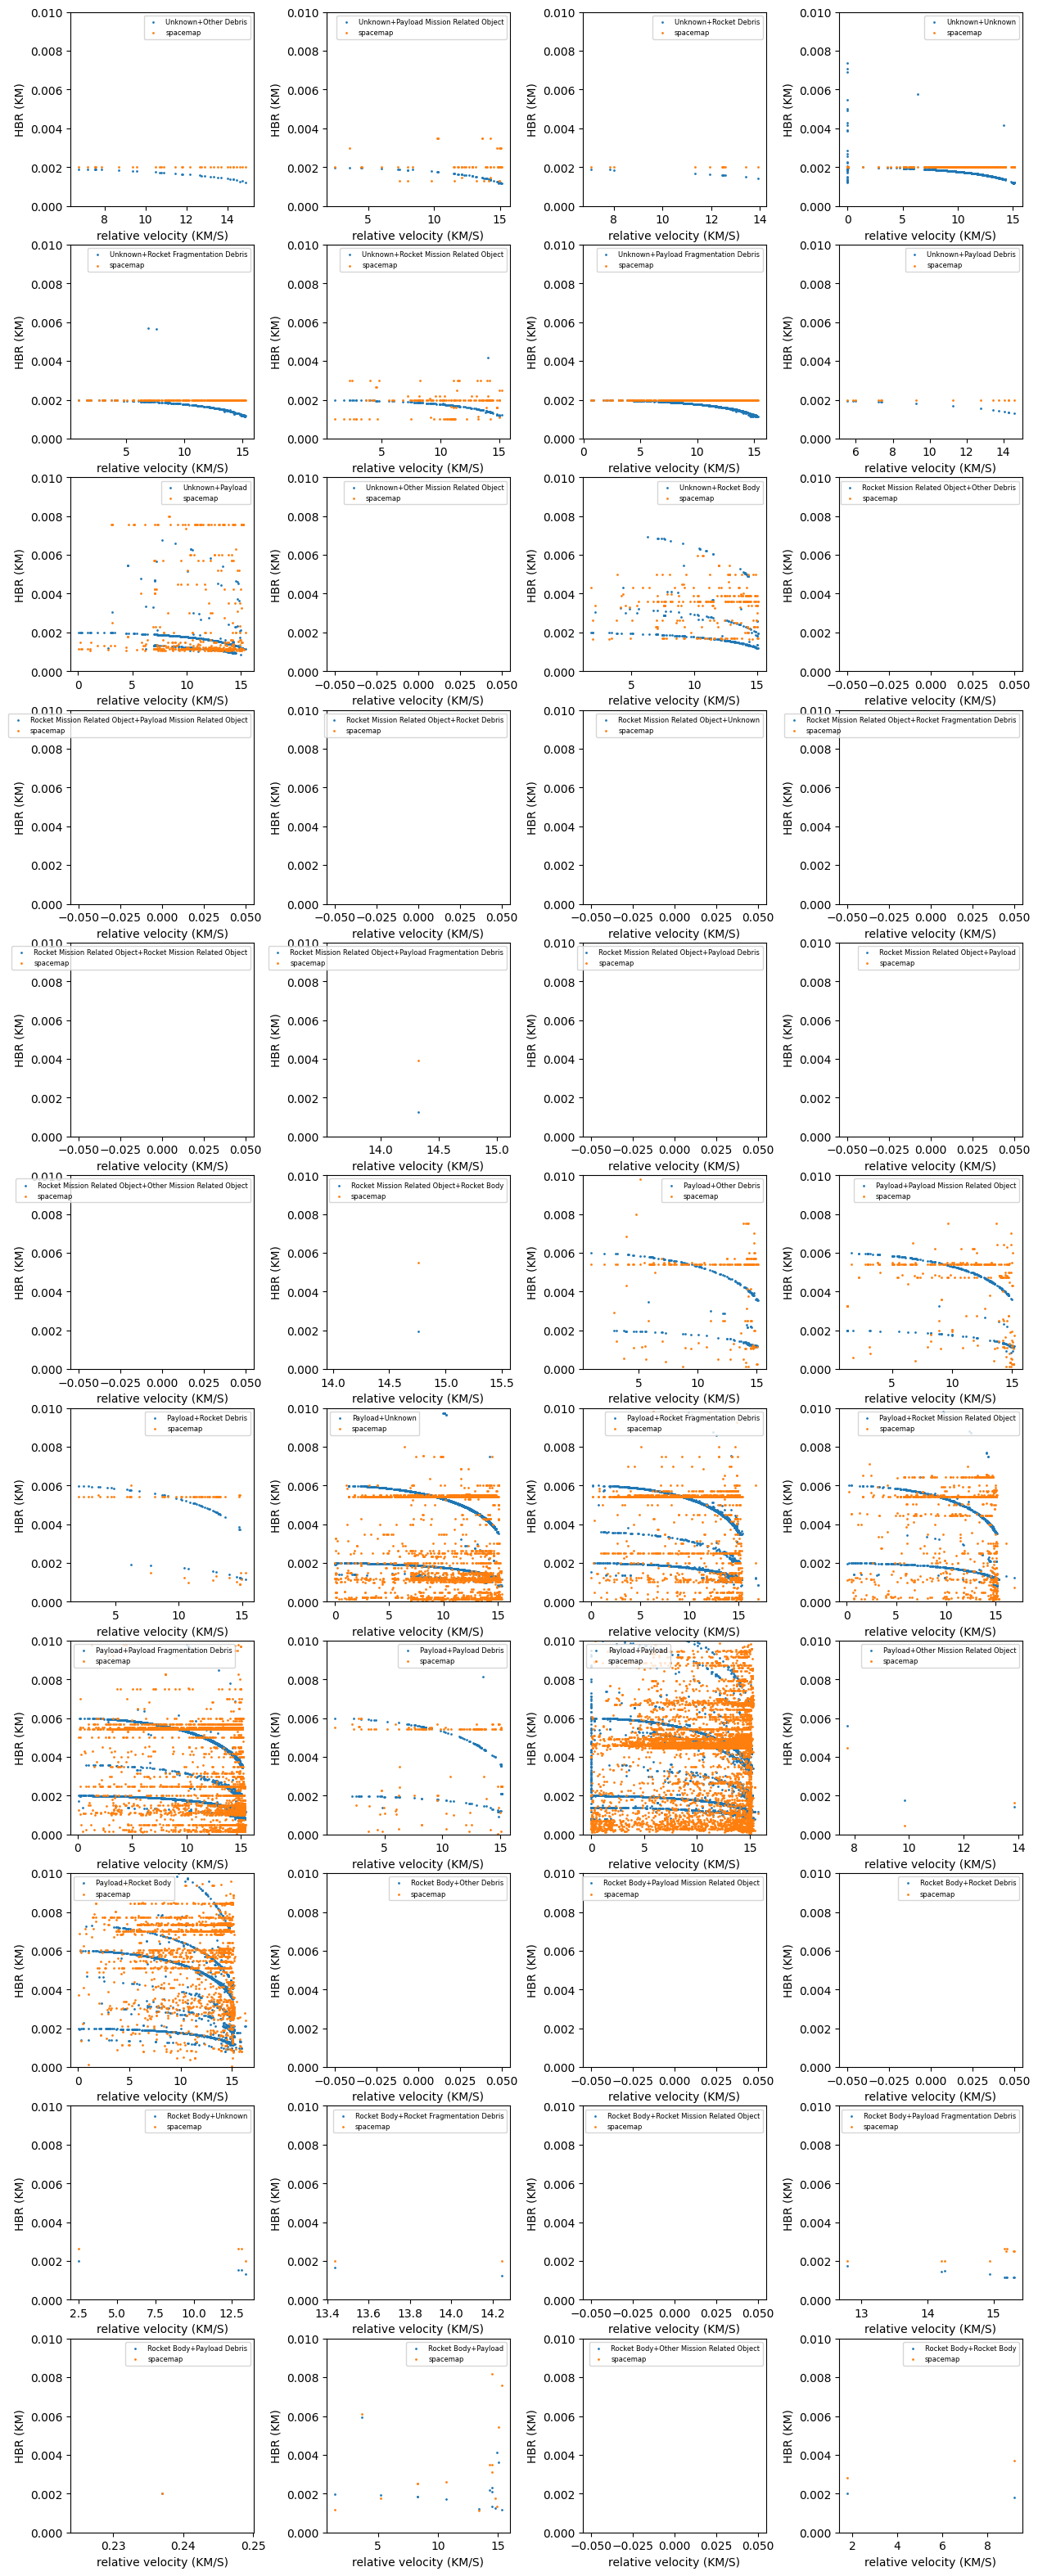

In [12]:
data_ca = pd.read_csv('../conjunction_assesement_result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h_HBR.csv')
data_ca = data_ca.fillna('No shape')

primary_object_class_set = list(set(data_ca['OBJECT_CLASS_1']))
secondary_object_class_set = list(set(data_ca['OBJECT_CLASS_2']))

fig, axes = plt.subplots(11, 4, figsize=(15, 40))
count = 0
for j in tqdm(primary_object_class_set):
    for k in secondary_object_class_set:
        x1, y1, z1 = [], [], []
        for i in range(len(data_ca)):
            if data_ca['OBJECT_CLASS_1'][i] == j and data_ca['OBJECT_CLASS_2'][i] == k:
                x1.append(data_ca['TCA_RELATIVE_SPEED'][i])
                y1.append(data_ca['HBR_CELESTRAK'][i])
                z1.append(data_ca['HBR_SPACEMAP'][i])

        # Get the current subplot (ax) based on the count
        ax = axes[count // 4, count % 4]

        ax.scatter(x1, y1, s=1, label=f'{j}+{k}')
        ax.scatter(x1, z1, s=1, label='spacemap')
        ax.set_xlabel('relative velocity (KM/S)')
        ax.set_ylim(0, 0.01)
        ax.set_ylabel('HBR (KM)')
        ax.legend(fontsize=6)
        count += 1
plt.subplots_adjust(wspace=0.4, hspace=0.2) 
plt.show()

## **Unknown Primary Object에 대한 상대 속도 및 HBR 관계 -> 함수 fitting**
전체 분포 중 일관된 형태를 띄는 부분만 추출해서 fitting

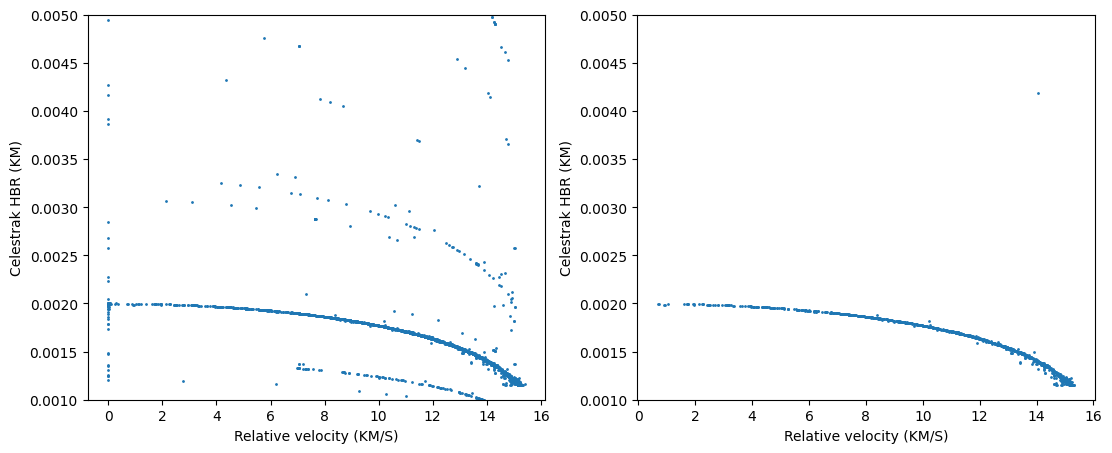

In [29]:
data = pd.read_csv('../conjunction_assesement_result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h_HBR.csv')
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121) 
relative_velocity = []
hbr = []
for i in range(len(data)):
    if data['OBJECT_CLASS_1'][i]=='Unknown' :
        relative_velocity.append(data['TCA_RELATIVE_SPEED'][i])
        hbr.append(data['HBR_CELESTRAK'][i])

ax1.scatter(relative_velocity,hbr,s=1)
ax1.set_ylim(0.001,0.005)
ax1.set_ylabel('Celestrak HBR (KM)')
ax1.set_xlabel('Relative velocity (KM/S)')

# 예외 케이스 뺴고 다 반영해서  함수fitting 한다.
ax2 = fig.add_subplot(122) 
relative_velocity, hbr = [], []
for i in range(len(data)):
    if data['OBJECT_CLASS_1'][i]=='Unknown'  and (data['OBJECT_CLASS_2'][i]=='Rocket Mission Related Object' 
         or data['OBJECT_CLASS_2'][i]=='Rocket Debris' or data['OBJECT_CLASS_2'][i]=='Other Debris' 
         or data['OBJECT_CLASS_2'][i]=='Payload Debris'or data['OBJECT_CLASS_2'][i]=='Rocket Fragmentation Debris'
         or data['OBJECT_CLASS_2'][i]=='Payload Fragmentation Debris' or data['OBJECT_CLASS_2'][i]=='Payload Mission Related Object'):

        relative_velocity.append(data['TCA_RELATIVE_SPEED'][i])
        hbr.append(data['HBR_CELESTRAK'][i])

ax2.scatter(relative_velocity,hbr,s=1)
ax2.set_ylim(0.001,0.005)
ax2.set_ylabel('Celestrak HBR (KM)')
ax2.set_xlabel('Relative velocity (KM/S)')
plt.subplots_adjust(hspace=0.5)
plt.show()
      

C:\Users\VDRC\AppData\Local\Temp\ipykernel_20860\2711383534.py:49: RuntimeWarning: invalid value encountered in log
  return a *np.log(list(map(lambda x: x * b, x))) + c
C:\Users\VDRC\AppData\Local\Temp\ipykernel_20860\2711383534.py:49: RuntimeWarning: divide by zero encountered in log
  return a *np.log(list(map(lambda x: x * b, x))) + c


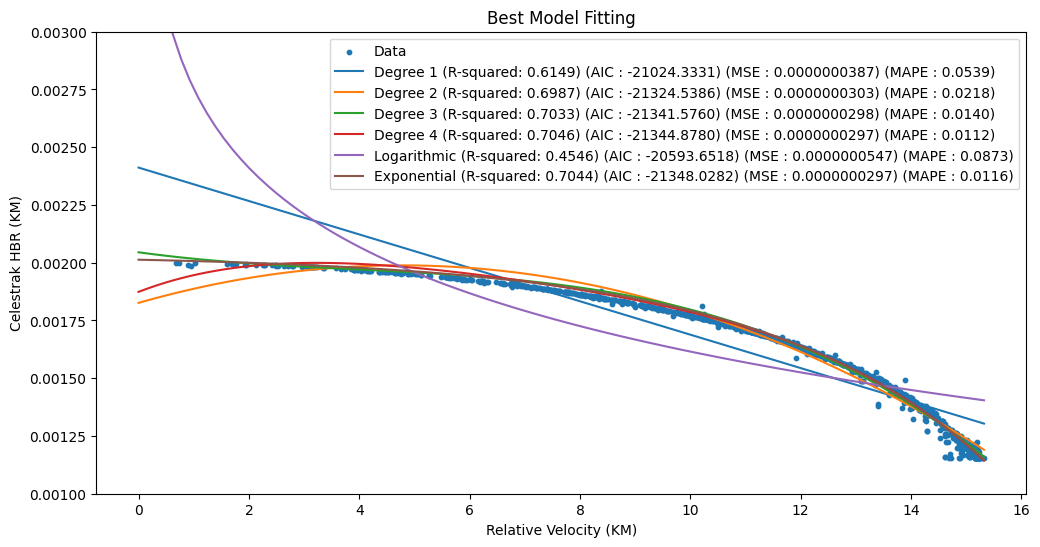

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def calculate_aic(y, y_pred, num_params):
    resid = y - y_pred
    sse = np.sum(resid**2)
    aic = len(y) * np.log(sse / len(y)) + 2 * num_params
    return aic
def polynomial_model(x, *coeffs):
    return np.polyval(coeffs, x)

x = relative_velocity
y = hbr

# Initialize variables for the best model
best_degree = None
best_params = None
best_aic = float('inf')
best_r2 = -1

max_degree = 4  # Maximum polynomial degree to test

plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Data', s=10)

# Polynomial model
for degree in range(1, max_degree + 1):
    
    coeffs, _ = curve_fit(polynomial_model, x, y, maxfev=10000, p0=np.random.randn(degree + 1))
    y_pred = polynomial_model(x, *coeffs)

    r2 = r2_score(y, y_pred)
    aic = calculate_aic(y, y_pred, degree + 1)
    mse = mean_squared_error(y, y_pred)
    mape =mean_absolute_percentage_error(y, y_pred)

    x_fit =np.linspace(0,max(x), 100)
    y_fit = polynomial_model(x_fit, *coeffs)
    label = f'Degree {degree} (R-squared: {r2:.4f}) (AIC : {aic:.4f}) (MSE : {mse:.10f}) (MAPE : {mape:.4f})'
    plt.plot(x_fit, y_fit, label=label)


# Logarithmic model
def logarithmic_model(x, a, b, c):
    return a *np.log(list(map(lambda x: x * b, x))) + c

log_params, _ = curve_fit(logarithmic_model, x, y, maxfev=10000)
y_pred_log = logarithmic_model(x, *log_params)

r2_log = r2_score(y, y_pred_log)
aic_log = calculate_aic(y, y_pred_log, 3)
mse_log = mean_squared_error(y, y_pred_log)
mape_log =mean_absolute_percentage_error(y, y_pred_log)

x_fit_log = np.linspace(0,max(x), 100)
y_fit_log = logarithmic_model(x_fit_log, *log_params)
plt.plot(x_fit_log, y_fit_log, label=f'Logarithmic (R-squared: {r2_log:.4f}) (AIC : {aic_log:.4f}) (MSE : {mse_log:.10f}) (MAPE : {mape_log:.4f})')



# Exponential model
def exponential_model(x, a, b, c):
    return a * np.exp(list(map(lambda x: x * b, x))) + c

exp_params, _ = curve_fit(exponential_model, x, y, maxfev=10000)

y_pred_exp = exponential_model(x, *exp_params)
r2_exp = r2_score(y, y_pred_exp)
aic_exp = calculate_aic(y, y_pred_exp, 3)

mse_exp = mean_squared_error(y, y_pred_exp)
mape_exp =mean_absolute_percentage_error(y, y_pred_exp)
x_fit_exp = np.linspace(0,max(x), 100)
y_fit_exp = exponential_model(x_fit_exp, *exp_params)
plt.plot(x_fit_exp, y_fit_exp, label=f'Exponential (R-squared: {r2_exp:.4f}) (AIC : {aic_exp:.4f}) (MSE : {mse_exp:.10f}) (MAPE : {mape_exp:.4f})')



plt.legend(fontsize=10)
plt.xlabel('Relative Velocity (KM)')
plt.ylabel('Celestrak HBR (KM)')
plt.ylim(0.001, 0.003)
plt.title('Best Model Fitting')
plt.show()



## **함수 fitting 적용 전 결과**

총 pair 개수: 1232
1e-1 범위 밖 개수: 0
1e-1 범위 내 개수 : 1232
범위 밖 비율 : 0.0%
범위 내 비율 : 100.0%


Text(1302, 0.1, '0.1')

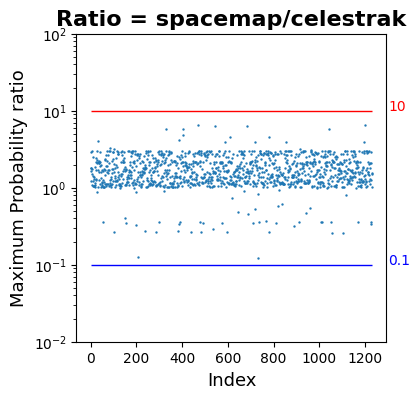

In [68]:
data_before_fitting = pd.read_csv('../conjunction_assesement_result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h_HBR.csv')
data_before_fitting = data_before_fitting[data_before_fitting['OBJECT_CLASS_1']=='Unknown']

data_before_fitting = data_before_fitting [(data_before_fitting['OBJECT_CLASS_1']=='Unknown') & ((data_before_fitting['OBJECT_CLASS_2']=='Rocket Mission Related Object')
        | (data_before_fitting['OBJECT_CLASS_2']=='Rocket Debris') | (data_before_fitting['OBJECT_CLASS_2']=='Other Debris') 
        | (data_before_fitting['OBJECT_CLASS_2']=='Payload Debris')| (data_before_fitting['OBJECT_CLASS_2']=='Rocket Fragmentation Debris')
        | (data_before_fitting['OBJECT_CLASS_2']=='Payload Fragmentation Debris') | (data_before_fitting['OBJECT_CLASS_2']=='Payload Mission Related Object'))]

data_in_confidence_interval  = [value for value in data_before_fitting['ERROR(RATIO)'] if value >= 0.1 and value <= 10 ]

print("총 pair 개수:", len(data_before_fitting))
print("1e-1 범위 밖 개수:", len(data_before_fitting['ERROR(RATIO)'])- len(data_in_confidence_interval))
print('1e-1 범위 내 개수 :',len(data_in_confidence_interval))
print(f"범위 밖 비율 : {round((len(data_before_fitting['ERROR(RATIO)'])- len(data_in_confidence_interval))*100/len(data_before_fitting['ERROR(RATIO)']),2)}%")
print(f"범위 내 비율 : {round(len(data_in_confidence_interval)*100/len(data_before_fitting['ERROR(RATIO)']),2)}%")

plt.figure(figsize=(4,4))
plt.scatter(np.arange(len(data_before_fitting['ERROR(RATIO)'])),data_before_fitting['ERROR(RATIO)'],s=0.5)
plt.title('Ratio = spacemap/celestrak', fontsize=16, fontweight='bold')
plt.xlabel(xlabel="Index",fontsize=13)
plt.ylabel(ylabel="Maximum Probability ratio",fontsize=13)
plt.ylim(0.01,100)
plt.yscale('log')
plt.hlines(10, 0, len(data_before_fitting), color='red', linestyle='solid', linewidth=1)
plt.hlines(0.1, 0, len(data_before_fitting), color='b', linestyle='solid', linewidth=1)
plt.text(len(data_before_fitting['ERROR(RATIO)'])+70, 10, f'{10}', fontsize=10, color='red')
plt.text(len(data_before_fitting['ERROR(RATIO)'])+70, 0.1, f'{0.1}', fontsize=10, color='b')


## **함수 fitting 적용 후 결과**

In [27]:
def exponential_model2(x, a, b, c):
    return a * np.exp(b*x) + c

총 pair 개수: 1232
1e-1 범위 밖 개수: 2
1e-1 범위 내 개수 : 1230
범위 밖 비율 : 0.16%
범위 내 비율 : 99.84%


Text(1302, 0.1, '0.1')

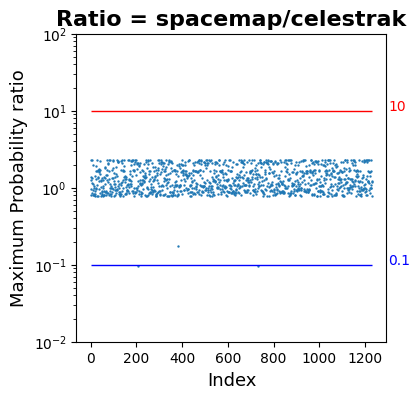

In [69]:
data_before_fitting = pd.read_csv('../conjunction_assesement_result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h_Unknown_HBR.csv')
data_before_fitting = data_before_fitting[data_before_fitting['OBJECT_CLASS_1']=='Unknown']

data_before_fitting = data_before_fitting [(data_before_fitting['OBJECT_CLASS_1']=='Unknown') & ((data_before_fitting['OBJECT_CLASS_2']=='Rocket Mission Related Object')
        | (data_before_fitting['OBJECT_CLASS_2']=='Rocket Debris') | (data_before_fitting['OBJECT_CLASS_2']=='Other Debris') 
        | (data_before_fitting['OBJECT_CLASS_2']=='Payload Debris')| (data_before_fitting['OBJECT_CLASS_2']=='Rocket Fragmentation Debris')
        | (data_before_fitting['OBJECT_CLASS_2']=='Payload Fragmentation Debris') | (data_before_fitting['OBJECT_CLASS_2']=='Payload Mission Related Object'))]

data_in_confidence_interval  = [value for value in data_before_fitting['ERROR(RATIO)'] if value >= 0.1 and value <= 10 ]

print("총 pair 개수:", len(data_before_fitting))
print("1e-1 범위 밖 개수:", len(data_before_fitting['ERROR(RATIO)'])- len(data_in_confidence_interval))
print('1e-1 범위 내 개수 :',len(data_in_confidence_interval))
print(f"범위 밖 비율 : {round((len(data_before_fitting['ERROR(RATIO)'])- len(data_in_confidence_interval))*100/len(data_before_fitting['ERROR(RATIO)']),2)}%")
print(f"범위 내 비율 : {round(len(data_in_confidence_interval)*100/len(data_before_fitting['ERROR(RATIO)']),2)}%")

plt.figure(figsize=(4,4))
plt.scatter(np.arange(len(data_before_fitting['ERROR(RATIO)'])),data_before_fitting['ERROR(RATIO)'],s=0.5)
plt.title('Ratio = spacemap/celestrak', fontsize=16, fontweight='bold')
plt.xlabel(xlabel="Index",fontsize=13)
plt.ylabel(ylabel="Maximum Probability ratio",fontsize=13)
plt.ylim(0.01,100)
plt.yscale('log')
plt.hlines(10, 0, len(data_before_fitting), color='red', linestyle='solid', linewidth=1)
plt.hlines(0.1, 0, len(data_before_fitting), color='b', linestyle='solid', linewidth=1)
plt.text(len(data_before_fitting['ERROR(RATIO)'])+70, 10, f'{10}', fontsize=10, color='red')
plt.text(len(data_before_fitting['ERROR(RATIO)'])+70, 0.1, f'{0.1}', fontsize=10, color='b')